The data for the project is taken from kaggle https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification.

In the working directory I created a folder data with three empty directories train, val and test.

Run the python notebook sequentially.

[forthebadge](https://forthebadge.com)

In [2]:
import os
import glob
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#!pip install split-folders

In [4]:
import splitfolders

In [5]:
"""os.getcwd()
os.chdir('C:\\Users\\Lenovo\\Desktop\\Omdena')"""

"os.getcwd()\nos.chdir('C:\\Users\\Lenovo\\Desktop\\Omdena')"

In [6]:
input_folder = 'Garbage classification/'
splitfolders.ratio(input_folder, output = 'data', seed = 42, ratio = (.7,.2,.1), group_prefix = None)

Copying files: 2527 files [00:03, 734.70 files/s]


In [7]:
train_path = 'data/train'
valid_path = 'data/val'

**Checking the number of images in the training set and validation set**

In [8]:
len(os.listdir(train_path + '/cardboard'))

282

In [9]:
len(os.listdir(train_path + '/glass'))

350

In [10]:
len(os.listdir(train_path + '/paper'))

415

In [11]:
len(os.listdir(train_path + '/plastic'))

337

In [12]:
len(os.listdir(train_path + '/trash'))

95

In [13]:
len(os.listdir(train_path + '/metal'))

287

In [14]:
len(os.listdir(valid_path + '/metal'))

82

**Plotting the images**

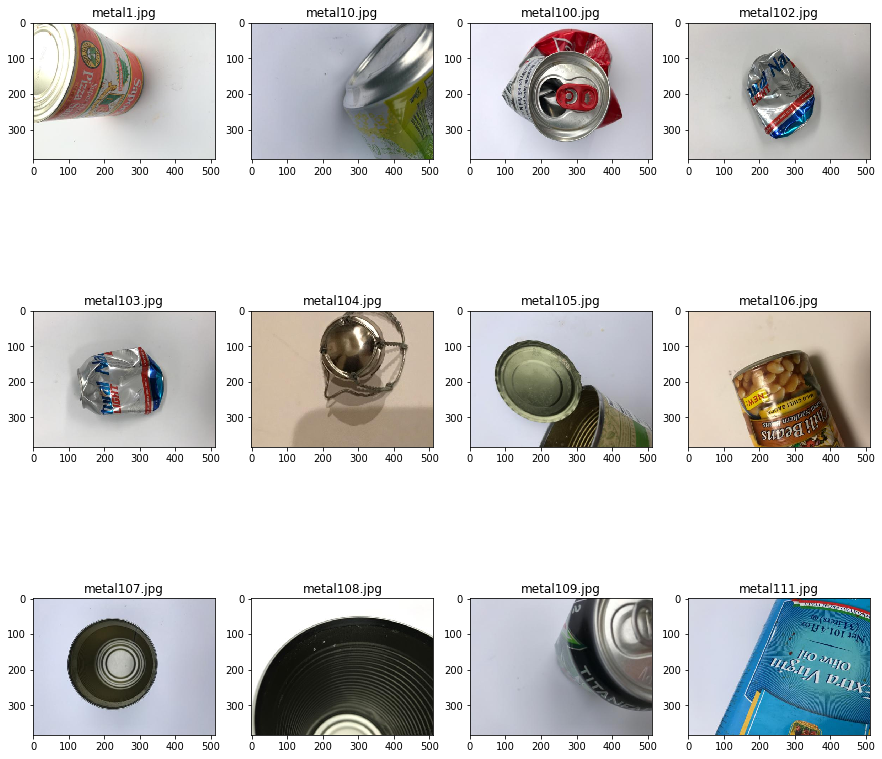

In [15]:
## Displaying the first 12 images of metal from the training set

fig = plt.figure(figsize = (15,15))
columns = 4
rows = 3
i = 1

for img_name in os.listdir(train_path+'/metal'):
    img = train_path + '/metal' +'/'+ img_name
    img = plt.imread(img)
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(img, interpolation = 'nearest')
    ax.title.set_text(img_name)
    i = i+1
    if i == columns*rows+1:
        break
    
plt.show()

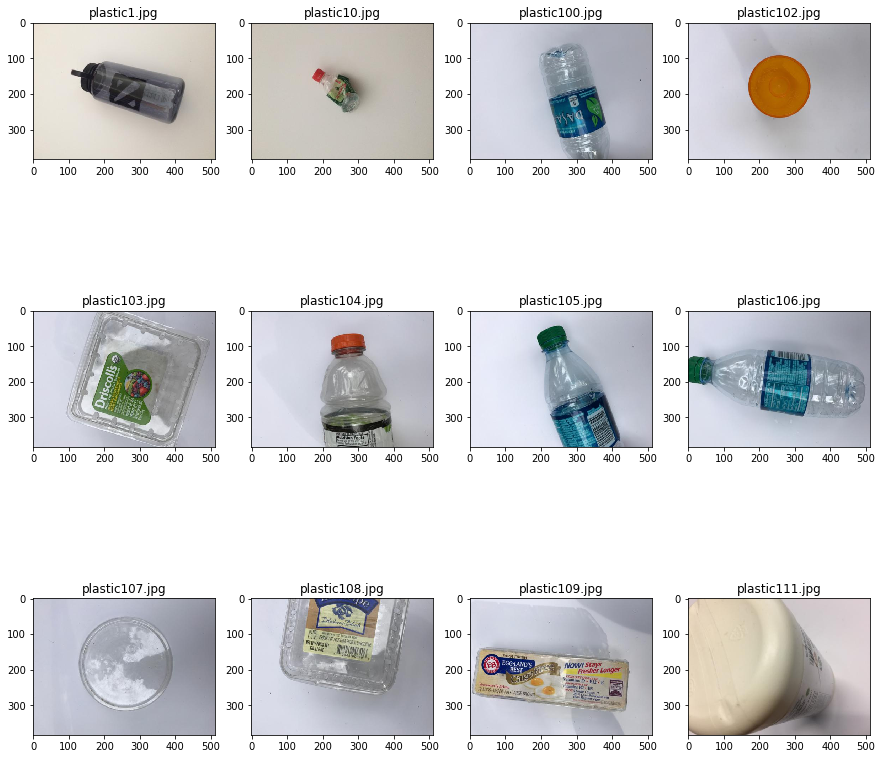

In [16]:
## Displaying the first 12 images of plastic from the training set

fig = plt.figure(figsize = (15,15))
columns = 4
rows = 3
i = 1

for img_name in os.listdir(train_path+'/plastic'):
    img = train_path + '/plastic/' + img_name
    img = plt.imread(img)
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(img, interpolation = 'nearest')
    ax.title.set_text(img_name)
    i = i+1
    if i == columns*rows+1:
        break
    
plt.show()

**Checking the dimension for each image**

In [17]:
images = os.listdir(train_path + '/metal/')

In [19]:
width, height = [], []

for image_name in images:
    img = plt.imread(train_path+ '/metal/' + image_name)
    w, h, c = img.shape
    width.append(w)
    height.append(h)

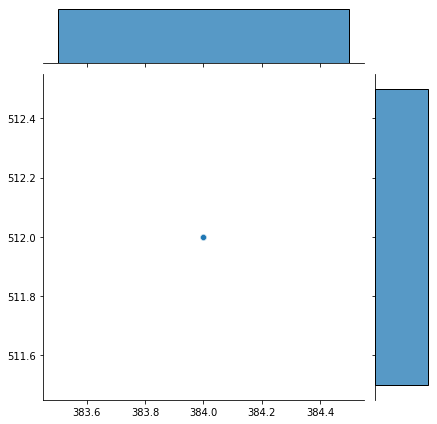

In [20]:
sns.jointplot( x = width, y = height, kind = 'scatter')
plt.show()

Most of the images have dimension either (384*512)

In [21]:
import numpy as np

print('Mean width: {}'.format(np.mean(width)))

print('Mean Height: {}'.format(np.mean(height)))

Mean width: 384.0
Mean Height: 512.0


We will keep the size of the image as (384*512 x 3)

In [22]:
IMAGE_SIZE = (384, 512, 3)

**Checking images are scaled or not**

In [23]:
img_name = os.listdir(train_path + '/metal')[0]
img = plt.imread(train_path+'/metal/'+img_name)

print('Maximum pizel value: {}'.format(np.max(img)))

print('Minimum pizel value: {}'.format(np.min(img)))

## Image is not scaled

Maximum pizel value: 255
Minimum pizel value: 0


**Creating Image Data Generator for Training and Validation set**

In [24]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 20,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [36]:
train_batches = train_datagen.flow_from_directory(directory = train_path,
                                                 target_size = (384, 512),
                                                 classes = ['cardboard', 'metal','paper','plastic','trash','glass'],
                                                 batch_size = 10,
                                                 shuffle = True, class_mode = 'categorical')

valid_batches = valid_datagen.flow_from_directory(directory = valid_path,
                                                 target_size = (384, 512),
                                                 classes = ['cardboard', 'metal','paper','plastic','trash','glass'],
                                                 batch_size = 10,
                                                 shuffle = False, class_mode = 'categorical')

Found 1766 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [37]:
train_batches.class_indices

{'cardboard': 0, 'metal': 1, 'paper': 2, 'plastic': 3, 'trash': 4, 'glass': 5}

**Let us see how the traing batch looks like**

In [38]:
imgs, labels = next(train_batches) ## getting first 10 images (1st batch)

## Everytime this line of code is run next 10 images are selected

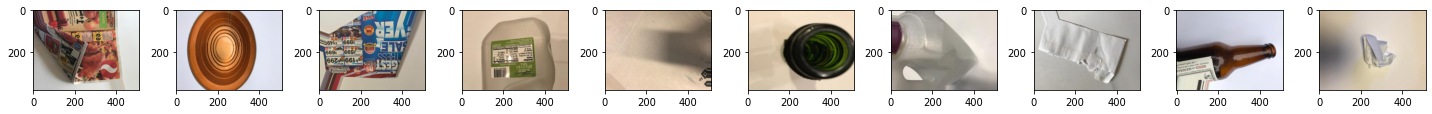

In [39]:
fig, axes = plt.subplots(1, 10, figsize = (20,20))
axes = axes.flatten()
for img, ax in zip(imgs, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [40]:
labels

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [41]:
img = imgs[0]

print('Maximum pixel value: {}'.format(np.max(img)))

print('Minimum pixel value: {}'.format(np.min(img)))

Maximum pixel value: 1.0
Minimum pixel value: 2.310047966602724e-05


Note how the image size and maximum and minimum pixel value are changed

Now the images are rescaled!!

**Building CNN model**

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.callbacks import EarlyStopping

In [43]:
model = Sequential()

model.add(Convolution2D(filters = 128, kernel_size =  (3,3), input_shape = (384,512,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Convolution2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Convolution2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(Convolution2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 6 , activation = 'softmax'))

In [44]:
model.compile(optimizer = 'adam' ,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 382, 510, 128)     3584      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 191, 255, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 189, 253, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 94, 126, 128)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 92, 124, 64)       73792     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 122, 64)       36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 61, 64)       

In [46]:
r = model.fit(train_batches,
                        steps_per_epoch = len(train_batches),
                        epochs = 10,
                        validation_data = valid_batches,
                        validation_steps = len(valid_batches),
                        callbacks = EarlyStopping(monitor='val_loss', patience = 2))

Epoch 1/10
177/177 [==============================] - 736s 4s/step - loss: 1.8346 - accuracy: 0.2203 - val_loss: 1.7272 - val_accuracy: 0.2346
Epoch 2/10
177/177 [==============================] - 714s 4s/step - loss: 1.6813 - accuracy: 0.2673 - val_loss: 1.4896 - val_accuracy: 0.3837
Epoch 3/10
177/177 [==============================] - 707s 4s/step - loss: 1.5848 - accuracy: 0.3545 - val_loss: 1.4332 - val_accuracy: 0.4235
Epoch 4/10
177/177 [==============================] - 710s 4s/step - loss: 1.6006 - accuracy: 0.3273 - val_loss: 1.6777 - val_accuracy: 0.3260
Epoch 5/10
177/177 [==============================] - 682s 4s/step - loss: 1.5115 - accuracy: 0.3828 - val_loss: 1.3892 - val_accuracy: 0.4394
Epoch 6/10
177/177 [==============================] - 652s 4s/step - loss: 1.4075 - accuracy: 0.4315 - val_loss: 1.3465 - val_accuracy: 0.4553
Epoch 7/10
177/177 [==============================] - 651s 4s/step - loss: 1.3312 - accuracy: 0.4745 - val_loss: 1.3713 - val_accuracy: 0.4791

In [ ]:
r.history.keys()

In [ ]:
plt.plot(r.history['accuracy'], label = 'Train')
plt.plot(r.history['val_accuracy'], label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(train_batches)
#train_batches.classes

In [ ]:
model.evaluate(valid_batches)

In [ ]:
train_pred = model.predict(train_batches)

In [ ]:
train_classes_pred = np.argmax(train_pred, axis = 1)

In [ ]:
train_classes_pred

In [ ]:
train_classes_actual = train_batches.classes

In [ ]:
train_classes_actual

In [ ]:
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_classes_actual, train_classes_pred)
print(cm)

In [ ]:
valid_classes = model.predict(valid_batches)
valid_classes_pred = np.argmax(valid_classes, axis = 1)
valid_classes_actual = valid_batches.classes
cm = confusion_matrix(valid_classes_actual, valid_classes_pred)
print(cm)